*Data Challenge for MODE 2022 Workshop on Differentiable Programming, Crete
Copyright (C) 2022 Giles C Strong*

*This program is free software: you can redistribute it and/or modify
it under the terms of the GNU Affero General Public License as published
by the Free Software Foundation, version 3 only of the License.*

*This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU Affero General Public License for more details.*

*You should have received a copy of the GNU Affero General Public License
along with this program.  If not, see <https://www.gnu.org/licenses/>.*

# Starter notebook

Welcome! This starter notebook for the challenge will cover:

1. Loading the data
1. Viewing the data
1. Applying a simple threshold-based approach
1. Evaluating performance using the intersection-over-union metric
1. Creating a submission with predictions for the test data

First, well load some basic modules. These may not be installed in your environment, so please install them if they are missing, e.g. with `pip` by uncommenting and running the cell below

In [1]:
# !pip install h5py matplotlib seaborn numpy tqdm

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
import h5py
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import math
from matplotlib.colors import LogNorm

## Data loading
If you haven't already downloaded the dataset, do so using, e.g. the uncommented command below. You only need to run this once.

In [4]:
# !mkdir data
# !wget -O data/train.h5 https://zenodo.org/record/6866891/files/train.h5
# !wget -O data/test.h5 https://zenodo.org/record/6866891/files/test.h5    

Point this to the directory where you have the data stored

In [5]:
DATA = Path('data')

Data files are in HDf5 format. The training file contains two datasets:
- `'x0'`: a set of voxelwise X0 predictions (float32)
- `'targs'`: a set of voxelwise classes (int):
    - 0 = soil
    - 1 = wall
    
The format of the datasets is a rank-4 array, with dimensions corresponding to (samples, z position, x position, y position).
All passive volumes are of the same size: 10x10x10 m, with cubic voxels of size 1x1x1 m, i.e. every passive volume contains 1000 voxels.
The arrays are ordered such that zeroth z layer is the bottom layer of the passive volume, and the ninth layer is the top layer.

Our job is to convert the X0 values into the target class values, for every voxel.

Since we want to evaluate the performance of our methods, we split off a portion of the training data to be used for validating performance, see e.g. https://www.fast.ai/2017/11/13/validation-sets/.

In [6]:
h5 = h5py.File(DATA/'train.h5', 'r')

Let's check the number of samples available:

In [7]:
h5['targs'].shape

(106129, 10, 10, 10)

So in total we have over 100,000 samples. This is quite large for the simple method we will apply, so for this tutorial we will limit ourselves to just a subsample of the data. This would also be recommended when developing more advanced methods, too, to allow us to quickly implement the method and make sure it gives reasonable results. Then the data count can be scaled up to further improve performance.

In [8]:
n = 10000
n_train = int(0.8*n)

In [9]:
train_x = h5['x0'][:n_train]
train_y = h5['targs'][:n_train]
valid_x = h5['x0'][n_train:n]
valid_y = h5['targs'][n_train:n]

In [10]:
train_x.shape, valid_y.shape

((8000, 10, 10, 10), (2000, 10, 10, 10))

In [11]:
h5.close()

We can look at the data and see that the X0 values are a dense set of float values, and the targets are a dense set of integers.

In [12]:
train_x[0]

array([[[0.08727431, 0.07093898, 0.08008487, 0.04614839, 0.10853043,
         0.04420735, 0.1558309 , 0.07996981, 0.174136  , 0.30670136],
        [0.1403093 , 0.05096206, 0.07112671, 0.05233372, 0.09752338,
         0.03558508, 0.12093341, 0.02633424, 0.696736  , 0.15838827],
        [0.11944672, 0.1870091 , 2.2604675 , 0.21106225, 0.08135942,
         0.03654002, 0.19790383, 0.18854019, 0.16660386, 0.1110109 ],
        [0.2975783 , 0.06085259, 0.2853277 , 0.5309467 , 0.03912209,
         0.10145387, 0.08290122, 0.09446712, 0.15089147, 0.20511687],
        [0.04160435, 0.09131287, 0.16170739, 0.07922516, 0.08154079,
         0.0141956 , 0.12535387, 0.12144243, 0.1161933 , 0.14393428],
        [0.07372857, 0.04466879, 0.03853433, 0.02916296, 0.01797015,
         0.0123551 , 0.01346337, 0.1278001 , 0.0422363 , 0.11120226],
        [0.10332484, 0.1771379 , 0.09642436, 0.03904482, 0.13777344,
         0.04747775, 0.06909999, 0.02438366, 0.23979525, 0.13537987],
        [0.1438076 , 0.0426

In [13]:
train_y[0]

array([[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],

       [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 

## Data viewing

Looking at raw 3D arrays of data is a bit uninformative, so in this section we'll plot it out.

Fist, we'll look at the targets from a top-down perspective, and plot them in x & y.

Below, we plot out 5 examples and flatten them along the z axis (`.any(0)`). The black sections are soil (class=0) and the white sections are the walls (class=1)

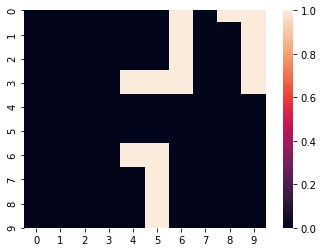

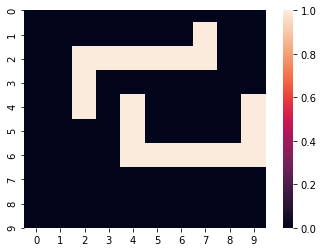

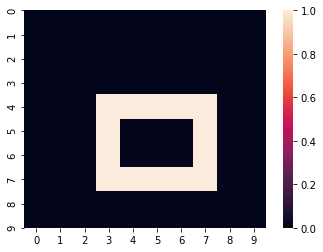

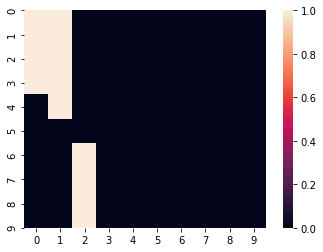

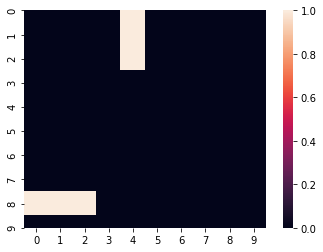

In [14]:
for targ in train_y[:5]:
    sns.heatmap(targ.any(0), square=True)
    plt.show()

To better show the 3D nature of the walls, we can plot the z-layers separately. The function below will plot one sample. Remember, that in the data the zeroth z-layer is the bottom (deepest) layer. To improve the visualisation, we will plot the most shallow layer first.

In [15]:
def plot_x0_targ(x0:np.ndarray, targ:np.ndarray) -> None:
    n_layers = x0.shape[0]
    fig, axs = plt.subplots(n_layers,2, figsize=(8, 8*16/9))
    pred_cbar_ax = fig.add_axes([0.45, 0.25, 0.03, 0.5])
    true_cbar_ax = fig.add_axes([0.90, 0.25, 0.03, 0.5])

    for layer in range(n_layers-1,-1,-1):
        sns.heatmap(x0[layer], ax=axs[n_layers-layer-1,0], vmin=np.nanmin(x0), vmax=np.nanmax(x0), cbar=(layer==0), cbar_ax=pred_cbar_ax if layer == 0 else None, square=True, cmap='viridis')
        sns.heatmap(targ[layer], ax=axs[n_layers-layer-1,1], vmin=np.nanmin(targ), vmax=np.nanmax(targ), cbar=(layer==0), cbar_ax=true_cbar_ax if layer == 0 else None, square=True, cmap='viridis')
        axs[n_layers-layer-1][0].set_ylabel(f"Layer {layer}")
    axs[-1][0].set_xlabel("X0")
    axs[-1][1].set_xlabel("Target")
    plt.show()

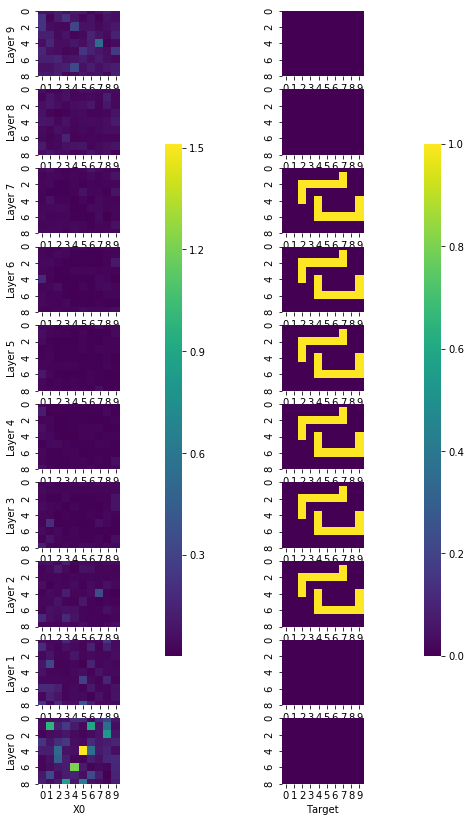

In [16]:
idx = 1
plot_x0_targ(train_x[idx], train_y[idx])

Due to the large range of X0s the colour scale gets compressed. Instead we can plot on a log-scale to better see differences in the low X0 region

In [17]:
def plot_x0_targ_log(x0:np.ndarray, targ:np.ndarray) -> None:
    n_layers = x0.shape[0]
    fig, axs = plt.subplots(n_layers,2, figsize=(8, 8*16/9))
    pred_cbar_ax = fig.add_axes([0.45, 0.25, 0.03, 0.5])
    true_cbar_ax = fig.add_axes([0.90, 0.25, 0.03, 0.5])
    cbar_ticks = [math.pow(10, i) for i in range(math.floor(math.log10(np.nanmin(x0))), 1+math.ceil(math.log10(np.nanmax(x0))))]
    log_norm = LogNorm(vmin=np.nanmin(x0), vmax=np.nanmax(x0))
    
    for layer in range(n_layers-1,-1,-1):
        sns.heatmap(x0[layer], ax=axs[n_layers-layer-1,0], vmin=np.nanmin(x0), vmax=np.nanmax(x0), cbar=(layer==0), cbar_ax=pred_cbar_ax if layer == 0 else None, square=True, cmap='viridis', norm=log_norm, cbar_kws={"ticks": cbar_ticks})
        sns.heatmap(targ[layer], ax=axs[n_layers-layer-1,1], vmin=np.nanmin(targ), vmax=np.nanmax(targ), cbar=(layer==0), cbar_ax=true_cbar_ax if layer == 0 else None, square=True, cmap='viridis')
        axs[n_layers-layer-1][0].set_ylabel(f"Layer {layer}")
    axs[-1][0].set_xlabel("X0")
    axs[-1][1].set_xlabel("Target")
    plt.show()

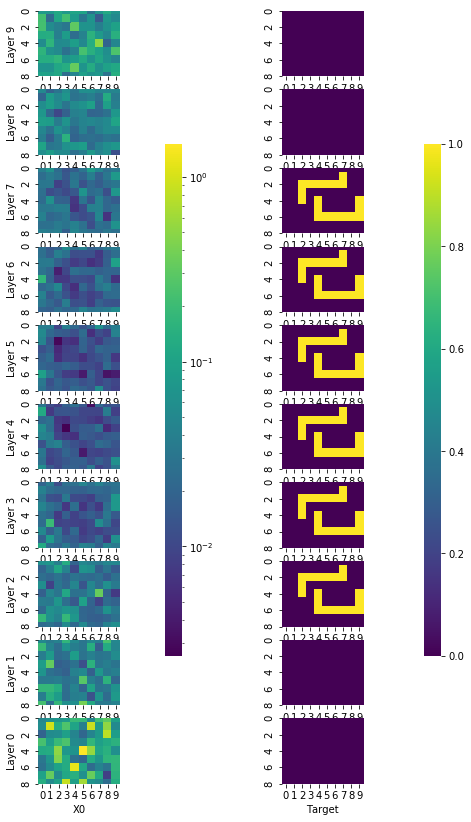

In [18]:
idx = 1
plot_x0_targ_log(train_x[idx], train_y[idx])

It's still a bit difficult to see differences in the low-value X0s. Plotting out the X0 distributions, we see a very long tail, with the majority of interesting information at below 0.1.

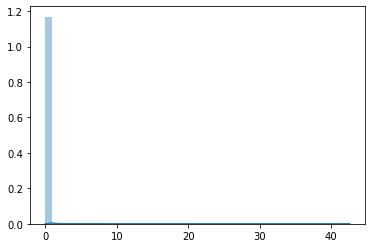

In [19]:
sns.distplot(train_x.flatten())

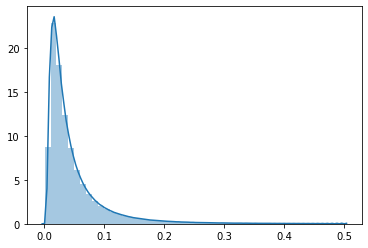

In [20]:
sns.distplot(train_x[train_x<0.5].flatten())

We can clip the plot values to 0.1 and try plotting again

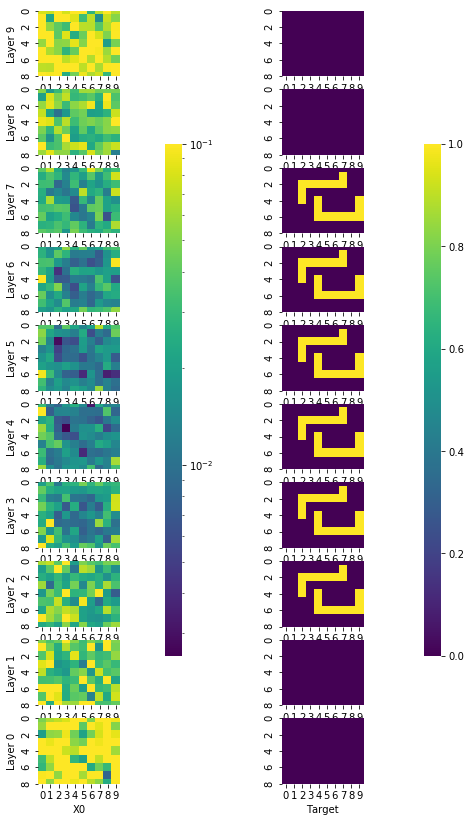

In [21]:
idx = 1
x0, targ = train_x[idx], train_y[idx]
plot_x0_targ_log(np.clip(x0, 0,0.1), targ)

We expect that the voxels with walls should have a lower X0 than the voxels with soil, and we can almost see this, however we the image is suffers a prediction bias that naturally causes the central layers to have lower X0 values than the top and bottom layers. We may wish to try to account for this somehow.

A quick and easy way to convert the X0 into classes is to apply a threshold on their values. Below the threshold are wall predictions, and above are soil predictions.

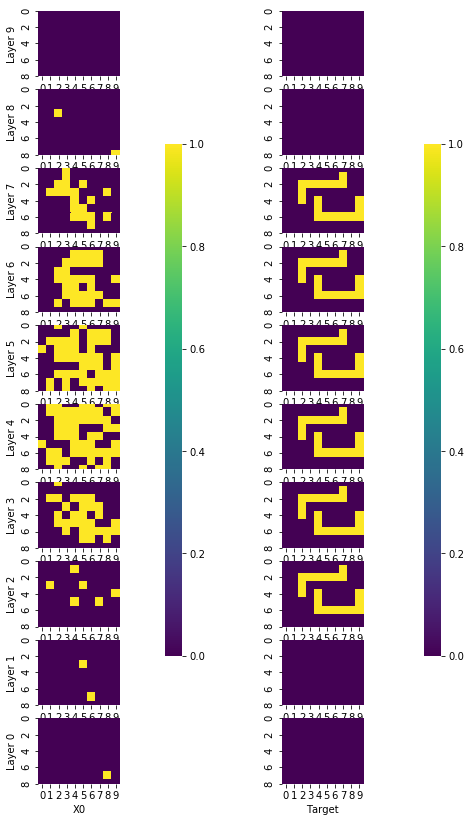

In [22]:
idx = 1
x0, targ = train_x[idx], train_y[idx]
plot_x0_targ(x0<0.015, targ)

## Threshold optimisation - single cut

We can build on the approach above by tuning the threshold. If we lower it, then in theory we should arrive at predictions that have a lower false positive rate for walls, however we may end up classifying many of the wall voxels as soil (high false negative rate). To govern the trade-off between these rates, we can look to the maximising the competition metric: the intersection over union. The intersection is the area of overlap between predicted values and true values, and the union is the summed area of predicted values and true values. By taking the ratio, we quantify the precision of our predictions: if we predicted a large area for one of the classes, then we would achieve a perfect prediction in all the voxels of that class, however if there are only a few voxels of that class, then the large union would reduce the IOU. This is computed separately for each class, and then we compute the mean IOU across the classes (and samples).

The IOU is a float between 0 and 1, with 1 being a perfect prediction for every class.

In [23]:
def binary_iou(preds:np.ndarray, targs:np.ndarray) -> float:
    # Add batch dimension if single sample passed
    if len(preds.shape) < 4: preds = preds[None]
    if len(targs.shape) < 4: targs = targs[None]
        
    # Creat masks for each class
    preds = preds.reshape(len(preds), 1, -1).astype(bool)
    targs = targs.reshape(len(targs), 1, -1).astype(bool)
    preds = preds.repeat(2, axis=1)
    targs = targs.repeat(2, axis=1)
    preds[:,0] = ~preds[:,0]
    targs[:,0] = ~targs[:,0]
    
    inter = (preds*targs).sum(-1)
    union = preds.sum(-1)+targs.sum(-1)-inter
    return ((inter+1e-17)/(union+1e-17)).mean()  # Small epsilon in case of zero union

This is the IOU for our initial threshold

In [24]:
binary_iou(train_x<0.015, train_y)

0.5187138044652

Let's see if we can optimise it by scanning across a range of thresholds

In [ ]:
x,y = [0],[binary_iou(train_x<=0, train_y)]
for p in tqdm(range(0,50)):
    x.append(np.percentile(train_x, p))
    y.append(binary_iou(train_x<=x[-1], train_y))

max_iou = np.max(y)
cut = x[np.argmax(y)]
plt.plot(x,y, label=f'Max IOU={max_iou:.3f} at cut of {x[np.argmax(y)]:.3E}')
plt.ylabel('IOU')
plt.xlabel('Cut')
plt.legend()

 34%|███▍      | 17/50 [00:03<00:06,  4.95it/s]

So, we can get a slight improvement by using a lower threshold than our initial guess

In [ ]:
idx = 1
x0, targ = train_x[idx], train_y[idx]
print(binary_iou(x0<cut, targ))
plot_x0_targ(x0<cut, targ)

## Threshold optimisation - cut per layer

We still want to account for the bias in the predictions caused by the depth in z. We can optimise separate thresholds for every layer by maximising the IOU for each layer

In [ ]:
x,y = [],[]
threshes = []
for z in tqdm(range(train_y.shape[1])):
    x.append([0])
    y.append([binary_iou(train_x[:,z]<=0, train_y[:,z])])
    for p in range(0,200):
        x[-1].append(np.percentile(train_x[:,z], p/10))
        y[-1].append(binary_iou(train_x[:,z]<=x[-1][-1], train_y[:,z]))

    plt.plot(x[-1],y[-1], label=f'layer {z}')
    plt.ylabel('IOU')
    plt.xlabel('Cut')
    plt.legend()
    plt.show()
    threshes.append(x[-1][np.argmax(y[-1])])
    print(np.max(y[-1]), threshes[-1])

We can that the thresholds reflect the X0 depth bias, with lower values being found in the central layers. The threshold for the shallowest layer is zero. Why do you think that is?

In [ ]:
threshes

Applying the thresholds is a bit more complicated now, but results in a slightly better IOU

In [ ]:
class_preds = np.zeros_like(train_x)
for i,t in enumerate(threshes):
    class_preds[:,i] = train_x[:,i] <= t

In [ ]:
binary_iou(class_preds, train_y)

In [ ]:
idx = 1
pred, targ = class_preds[idx], train_y[idx]
print(binary_iou(pred, targ))
plot_x0_targ(pred, targ)

## Validation

Given that we optimised the thresholds on the same data we have applied them, we need to get an accurate estimate of our generalised performance to unseen data. For this we can use the validation dataset.

In [ ]:
class_preds = np.zeros_like(valid_x)
for i,t in enumerate(threshes):
    class_preds[:,i] = valid_x[:,i] <= t

In [ ]:
binary_iou(class_preds, valid_y)

So a slight drop in IOU, but nothing drastic. Seems we haven't overfitted to the training data

## Submission prep

Let's say we are happy with our solution and we want to submit predictions for the test data. We first need to load the data, score it, and then save our predictions to a new file.

In [ ]:
with h5py.File(DATA/'test.h5') as h5:
    test_x = h5['x0'][()]

In [ ]:
len(test_x)

We compute our predictions just like we did on the validation data

In [ ]:
class_preds = np.zeros_like(test_x)
for i,t in enumerate(threshes):
    class_preds[:,i] = test_x[:,i] <= t

To submit predictions, please save them to a HDF5 file using the function below. The file name should use the format `[your_name]_test_preds.h5`

In [ ]:
NAME_AND_ID = 'MY_NAME_ID00'

In [ ]:
with h5py.File(f'{NAME_AND_ID}_test_preds.h5', 'w') as h5:
    h5.create_dataset("preds", data=class_preds.astype("int"), dtype="int", compression='lzf')